In [169]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid
from sklearn.metrics import log_loss, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [170]:
data = pd.read_csv('data/significant-features-data.csv')
data.head()

,Age at enrollment,Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Unemployment rate,Target,y_labels
0,0.056604,0.000000,0.000000,0.000000,0.0,0.00000,0.00,0.000000,0.372093,Dropout,-1
1,0.037736,0.133333,0.230769,0.741722,0.0,0.26087,0.30,0.735897,0.732558,Graduate,1
2,0.037736,0.000000,0.000000,0.000000,0.0,0.26087,0.00,0.000000,0.372093,Dropout,-1
3,0.056604,0.177778,0.230769,0.711447,0.0,0.26087,0.25,0.667692,0.209302,Graduate,1
4,0.528302,0.200000,0.192308,0.653422,0.0,0.26087,0.30,0.700000,0.732558,Graduate,1


In [171]:
feature_columns = data.columns.drop(['Target', 'y_labels'])
X = data[feature_columns].to_numpy(dtype=float)
y = data['y_labels'].to_numpy(dtype=int)

In [172]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

In [173]:
# Polynomial Kernel
def polynomial_kernel(A, B, *, degree=3, gamma=1., coef0=1.):
    """
    K(x, x') = (gamma * <x, x'> + coef0)^degree
    """
    return (gamma * (A @ B.T) + coef0) ** degree

In [257]:
# Gaussian Kernel
def gaussian_kernel(A, B, *, gamma=1.):
    """
    K(x, x') = exp( - gamma * ||x - x'||^2 )
    """
    A2 = (A**2).sum(1)[:, None]
    B2 = (B**2).sum(1)[None, :]
    return np.exp(-gamma * (A2 + B2 - 2 * (A @ B.T)))

In [174]:
def train_kernel_svm_sgd(X, y, kernel, T=1000, C=1.0, **kernel_params):
    """
    Dual-SGD for hinge-loss SVM using a precomputed Gram matrix.
    Returns the averaged alpha coefficients.
    """
    n = X.shape[0]
    # precompute Gram matrix
    K = kernel(X, X, **kernel_params)
    
    # betas accumulate raw counts; we'll convert to alphas each step
    beta = np.zeros(n)
    alpha_sum = np.zeros(n)
    
    for t in range(1, T + 1):
        # compute current alphas from beta
        alpha = beta / (2 * C * t)
        
        # uniformly pick one example at random
        j = np.random.randint(n)
        
        # decision function margin for j
        margin_j = y[j] * np.dot(alpha * y, K[:, j])
        
        # if margin_j < 1, we incur hinge loss → update beta_j
        if margin_j < 1:
            beta[j] += y[j]
        
        alpha_sum += alpha
    
    # return the averaged alpha over all iterations
    return alpha_sum / T

In [259]:
def predict_kernel_svm(alpha, X_train, X_eval, kernel, **kernel_params):
    """
    Predict sign( f(x) ) where
      f(x) = sum_i alpha_i * K(x_i, x)
    """
    return np.sign(alpha @ kernel(X_train, X_eval, **kernel_params))

In [260]:
def cross_validate(params, X, y, kernel, *, k_folds=5, T=1000):
    """
    Perform k-fold cross-validation for kernel SVM with given parameters
    Returns average accuracy across folds
    """
    C = params['C']
    kernel_params = {}
    for key, val in params.items():
        if key != 'C':
            kernel_params[key] = val

    acc = []
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        alpha = train_kernel_svm_sgd(X_tr, y_tr, kernel, C=C, T=T, **kernel_params)
        preds = predict_kernel_svm(alpha, X_tr, X_val, kernel, **kernel_params)

        acc.append((preds == y_val).mean())

    return np.mean(acc)

In [167]:
def grid_search_svm(X, y, kernel, param_grid, *, k_folds=5, T=1000, n_jobs=-1):
    """
    Perform grid search to find best hyperparameters
    Returns best parameters and best score
    """
    grid = list(ParameterGrid(param_grid))

    best_score = -float('inf')   # start lower than any real score
    best_params = None

    for params in grid:
        score = cross_validate(params, X, y, kernel, k_folds=k_folds, T=T)
        #print(f"Tested {params} → CV accuracy = {score:.4f}")

        if score > best_score:
            best_score  = score
            best_params = params

    return best_params, best_score

In [262]:
# Hyperparameter grid for Polynomial kernel
poly_grid = dict(
    degree=[2, 3, 4],                         
    gamma=[1e-4, 1e-3, 1e-2, 0.1, 1],         
    coef0=[0, 0.5, 1, 2],                     
    C=[
        1e-4, 3e-4, 1e-3, 3e-3,               
        1e-2, 3e-2, 1e-1, 0.3,                
        1, 3, 10                              
    ]
)

In [263]:
# Hyperparameter grid for Gaussian kernel
gaussian_grid = dict(
    gamma=[
        1e-5, 3e-5, 1e-4, 3e-4,            
        1e-3, 3e-3, 1e-2, 3e-2,
        1e-1, 3e-1, 1, 3                   
    ],
    C=[
        1e-4, 3e-4, 1e-3, 3e-3,            
        1e-2, 3e-2, 1e-1, 0.3,             
        1, 3, 10                           
    ]
)

In [158]:
# Perform grid search for polynomial kernel
print(">> Polynomial grid-search")
best_poly, poly_cv = grid_search_svm(X_train, y_train, polynomial_kernel, poly_grid)
print("Best poly params:", best_poly, "CV =", poly_cv)

>> Polynomial grid-search
Best poly params: {'C': 1, 'coef0': 0, 'degree': 4, 'gamma': 1} CV = 0.7858113777479444


In [157]:

# Perform grid search for Gaussian kernel
print("\n>> Gaussian grid-search")
best_gaussian, gaussian_cv = grid_search_svm(X_train, y_train, gaussian_kernel, gaussian_grid)
print("Best gaussian params:", best_gaussian, "CV =", gaussian_cv)


>> Gaussian grid-search
Best gaussian params: {'C': 0.1, 'gamma': 3} CV = 0.8013572906927496


In [165]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=15, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

In [164]:
def plot_roc_pr_curves(y_true_binary, y_scores):
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title('ROC Curve', fontsize=15, pad=20)
    ax1.legend(loc="lower right")
    ax1.grid(True)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)
    pr_auc = auc(recall, precision)
    
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title('Precision-Recall Curve', fontsize=15, pad=20)
    ax2.legend(loc="lower right")
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [163]:
def fit_and_eval(best_params, kernel, name, X_train, y_train, X_test, y_test):
    C = best_params['C']
    kernel_params = {}
    for key, val in best_params.items():
        if key != 'C':
            kernel_params[key] = val

    alpha = train_kernel_svm_sgd(X_train, y_train, kernel, C=C, T=1000, **kernel_params)
    
    # Compute decision scores (raw SVM output)
    decision_scores = alpha @ kernel(X_train, X_test, **kernel_params)
    
    # Predicted class labels
    preds = np.sign(decision_scores)
    
    # Probabilities for log-loss (sigmoid)
    probs = 1 / (1 + np.exp(-decision_scores))
    probs = np.vstack([1 - probs, probs]).T

    # True labels must be 0/1 for log-loss
    y_true_binary = (y_test + 1) // 2
    
    # Print metrics
    print(f"\n{name} kernel - Test Metrics:")
    print(f"  Accuracy     : {accuracy_score(y_test, preds):.4f}")
    print(f"  Log-Loss     : {log_loss(y_true_binary, preds):.4f}")
    print(f"  Precision    : {precision_score(y_test, preds):.4f}")
    print(f"  Recall       : {recall_score(y_test, preds):.4f}")
    print(f"  F1 Score     : {f1_score(y_test, preds):.4f}")
    
    # Plot visual metrics
    print(f"\nConfusion Matrix for {name} Kernel:")
    plot_confusion_matrix(y_test, preds, f"Confusion Matrix - {name} Kernel")
    
    print(f"\nROC and PR Curves for {name} Kernel:")
    plot_roc_pr_curves(y_true_binary, decision_scores)


Polynomial kernel - Test Metrics:
  Accuracy     : 0.7910
  Log-Loss     : 7.5345
  Precision    : 0.7818
  Recall       : 0.9601
  F1 Score     : 0.8618

Confusion Matrix for Polynomial Kernel:


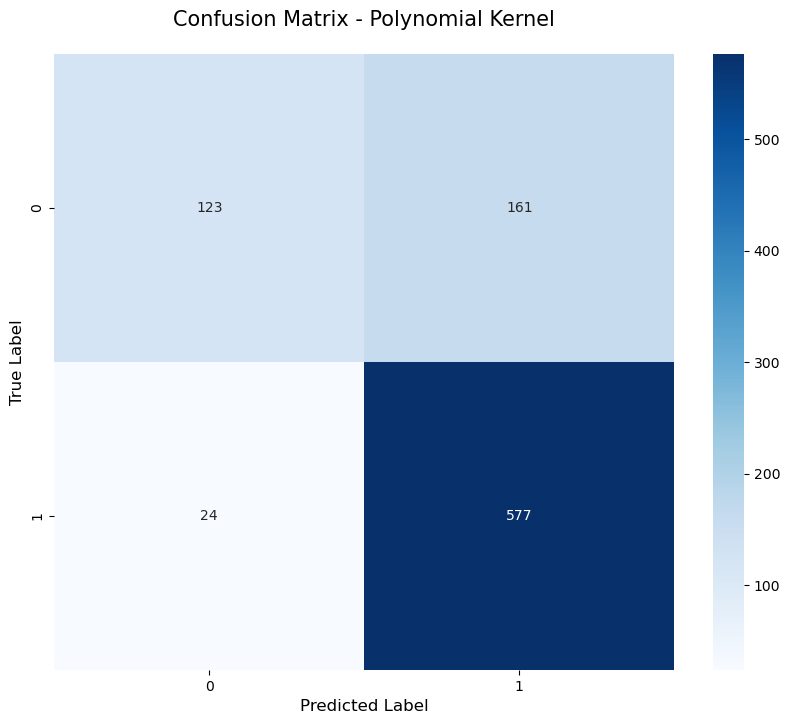


ROC and PR Curves for Polynomial Kernel:


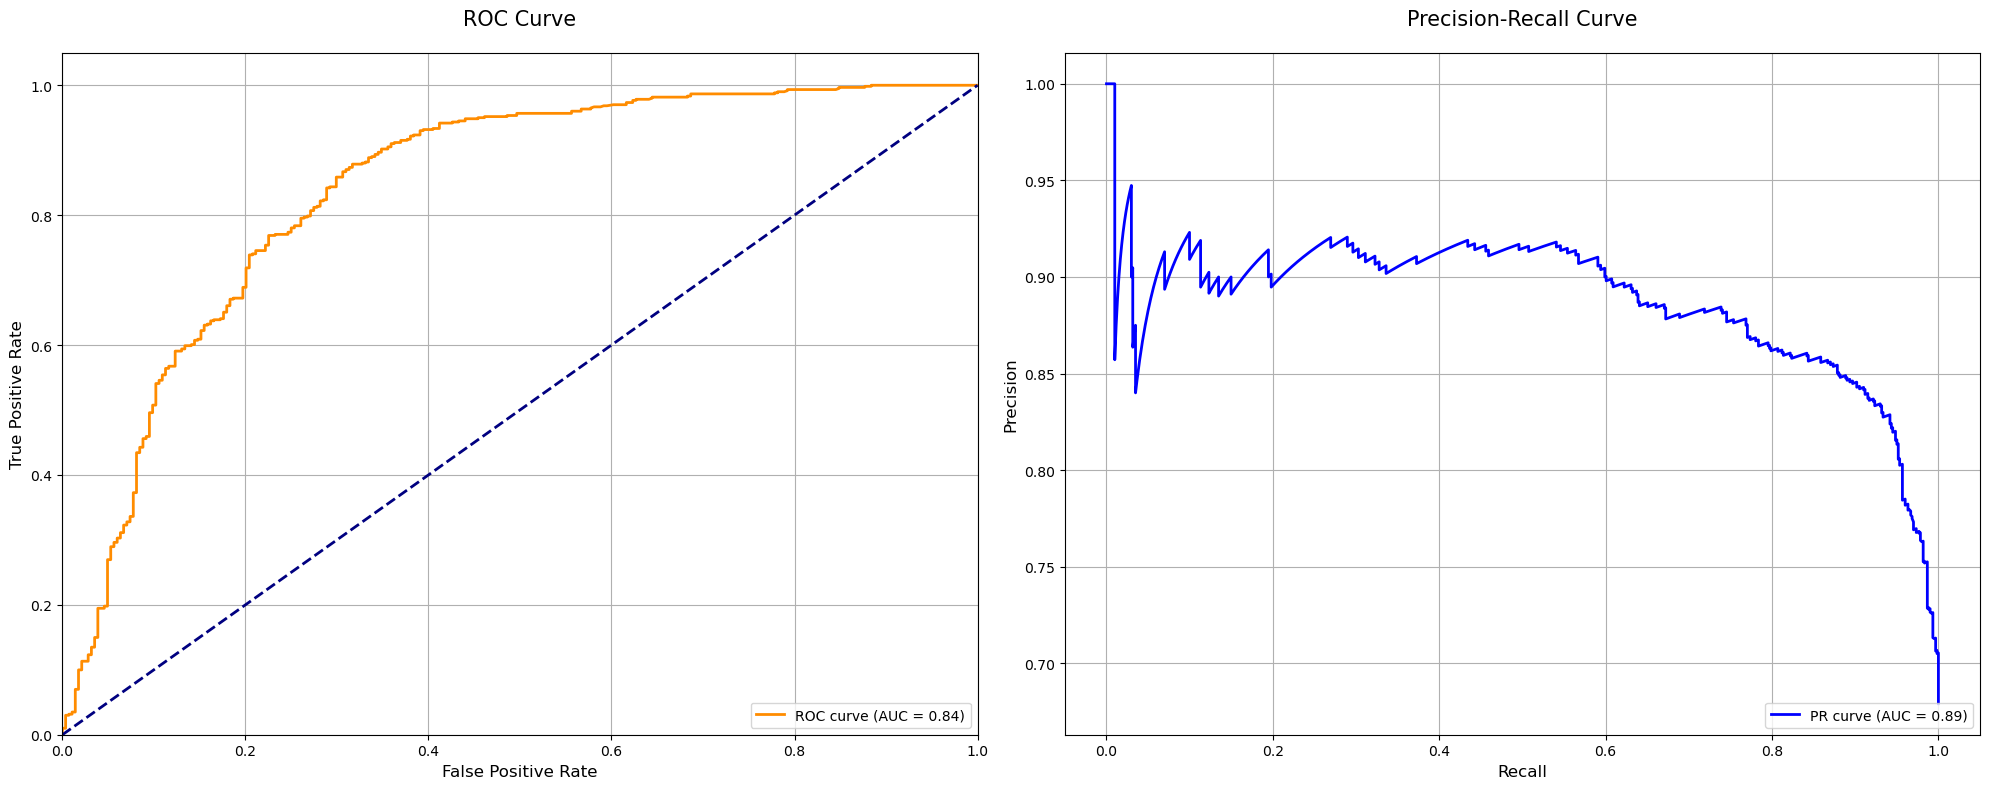

In [178]:
fit_and_eval(best_poly, polynomial_kernel, "Polynomial", X_train, y_train, X_test, y_test)


Gaussian kernel - Test Metrics:
  Accuracy     : 0.8203
  Log-Loss     : 6.4756
  Precision    : 0.8166
  Recall       : 0.9484
  F1 Score     : 0.8776

Confusion Matrix for Gaussian Kernel:


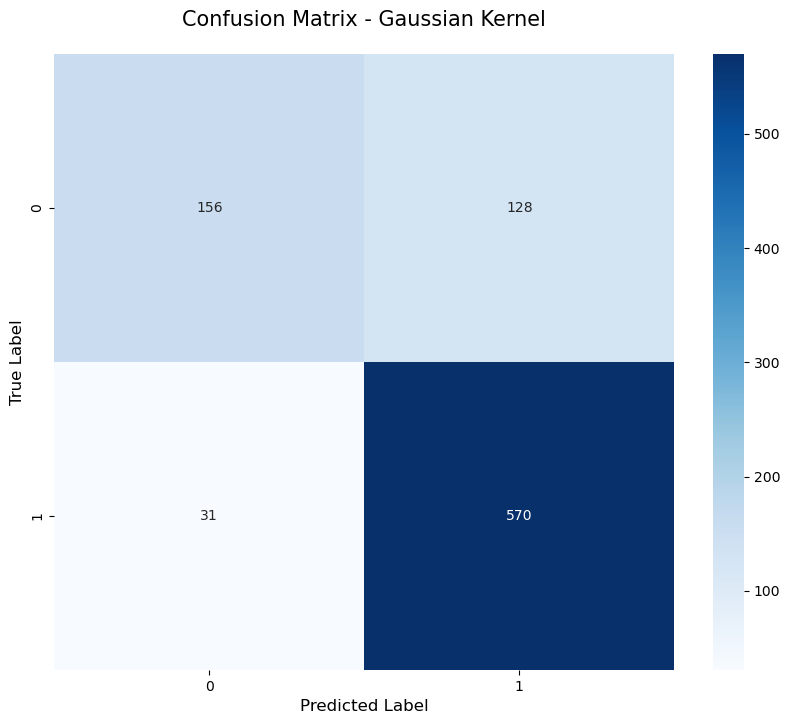


ROC and PR Curves for Gaussian Kernel:


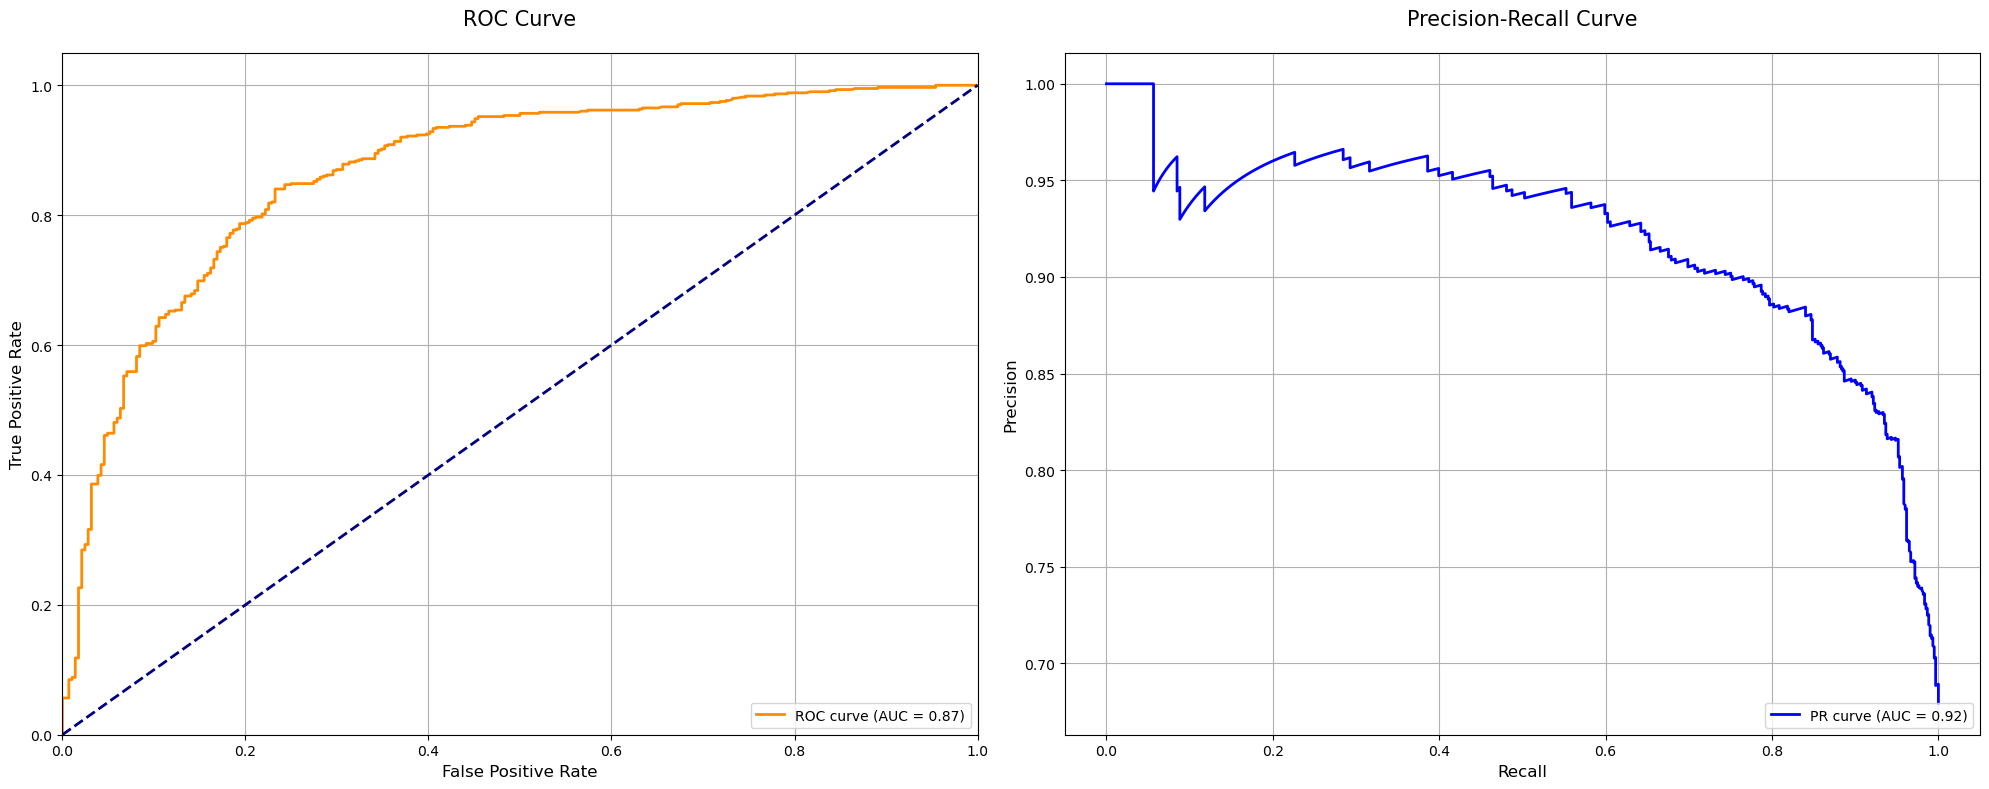

In [180]:
fit_and_eval(best_gaussian, gaussian_kernel, "Gaussian",  X_train, y_train, X_test, y_test)

Doing evaluation on processed data (data where ordinal values are removed, but insignifigant p values are not)

In [156]:
pre_processed_data = pd.read_csv('data/processed-data.csv')

pre_processed_feature_columns = pre_processed_data.columns.drop(['Target', 'y_labels'])
pre_processed_X = pre_processed_data[pre_processed_feature_columns].to_numpy(dtype=float)
pre_processed_y = pre_processed_data['y_labels'].to_numpy(dtype=int)

pp_X_train, pp_X_test, pp_y_train, pp_y_test = train_test_split(pre_processed_X, pre_processed_y, test_size=0.2, random_state=0, shuffle=True)

pre_processed_data.head()

,Previous qualification (grade),Admission grade,Age at enrollment,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target,y_labels
0,0.284211,0.340000,0.056604,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.000000,0.00,0.000000,0.0,0.372093,0.488889,0.766182,Dropout,-1
1,0.684211,0.500000,0.037736,0.0,0.230769,0.133333,0.230769,0.741722,0.0,0.0,0.26087,0.181818,0.30,0.735897,0.0,0.732558,0.111111,0.640687,Graduate,1
2,0.284211,0.313684,0.037736,0.0,0.230769,0.000000,0.000000,0.000000,0.0,0.0,0.26087,0.000000,0.00,0.000000,0.0,0.372093,0.488889,0.766182,Dropout,-1
3,0.284211,0.258947,0.056604,0.0,0.230769,0.177778,0.230769,0.711447,0.0,0.0,0.26087,0.303030,0.25,0.667692,0.0,0.209302,0.000000,0.124174,Graduate,1
4,0.052632,0.489474,0.528302,0.0,0.230769,0.200000,0.192308,0.653422,0.0,0.0,0.26087,0.181818,0.30,0.700000,0.0,0.732558,0.111111,0.640687,Graduate,1


In [159]:
#perfrom gird search again with new data. 
print(">> Polynomial grid-search for pre processed data")
best_poly_pp, poly_cv_pp = grid_search_svm(pp_X_train, pp_y_train, polynomial_kernel, poly_grid)
print("Best poly params for pre processed data:", best_poly, "CV =", poly_cv)

>> Polynomial grid-search for pre processed data
Best poly params for pre processed data: {'C': 1, 'coef0': 0, 'degree': 4, 'gamma': 1} CV = 0.7858113777479444


In [160]:
#perfom gaussian grid search with new data
print(">> gaussian grid-search")
best_gaussian_pp, gaussian_cv_pp = grid_search_svm(pp_X_train, pp_y_train, gaussian_kernel, gaussian_grid)
print("Best gaussian params for pre processed data:", best_gaussian_pp, "CV =", gaussian_cv_pp)

>> gaussian grid-search
Best gaussian params for pre processed data: {'C': 0.1, 'gamma': 3} CV = 0.792875921974764


testing with preprocessed data

polynomial kernel - Test Metrics:
  Accuracy     : 0.7921
  Log-Loss     : 7.4938
  Precision    : 0.8135
  Recall       : 0.9002
  F1 Score     : 0.8547

Confusion Matrix for polynomial Kernel:


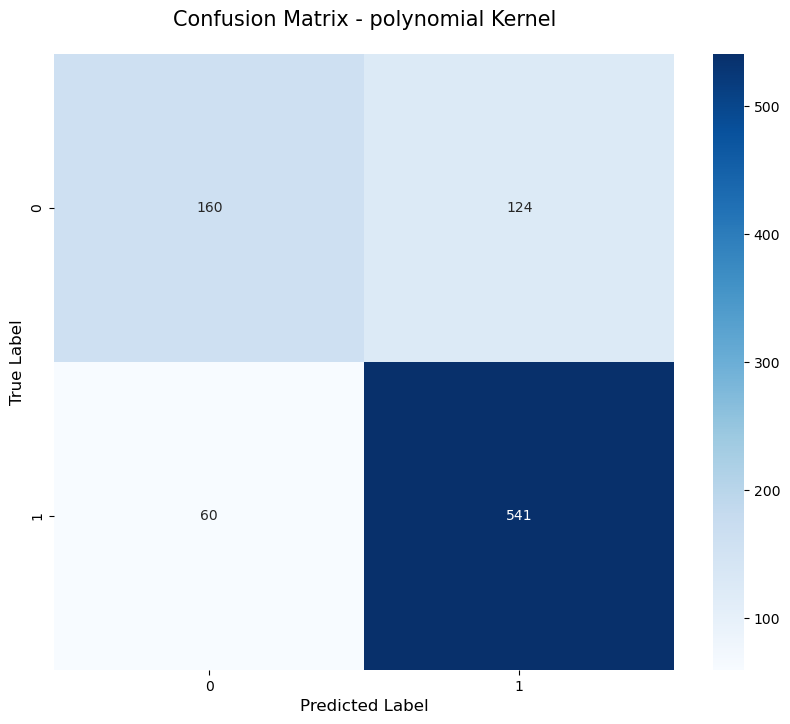


ROC and PR Curves for polynomial Kernel:


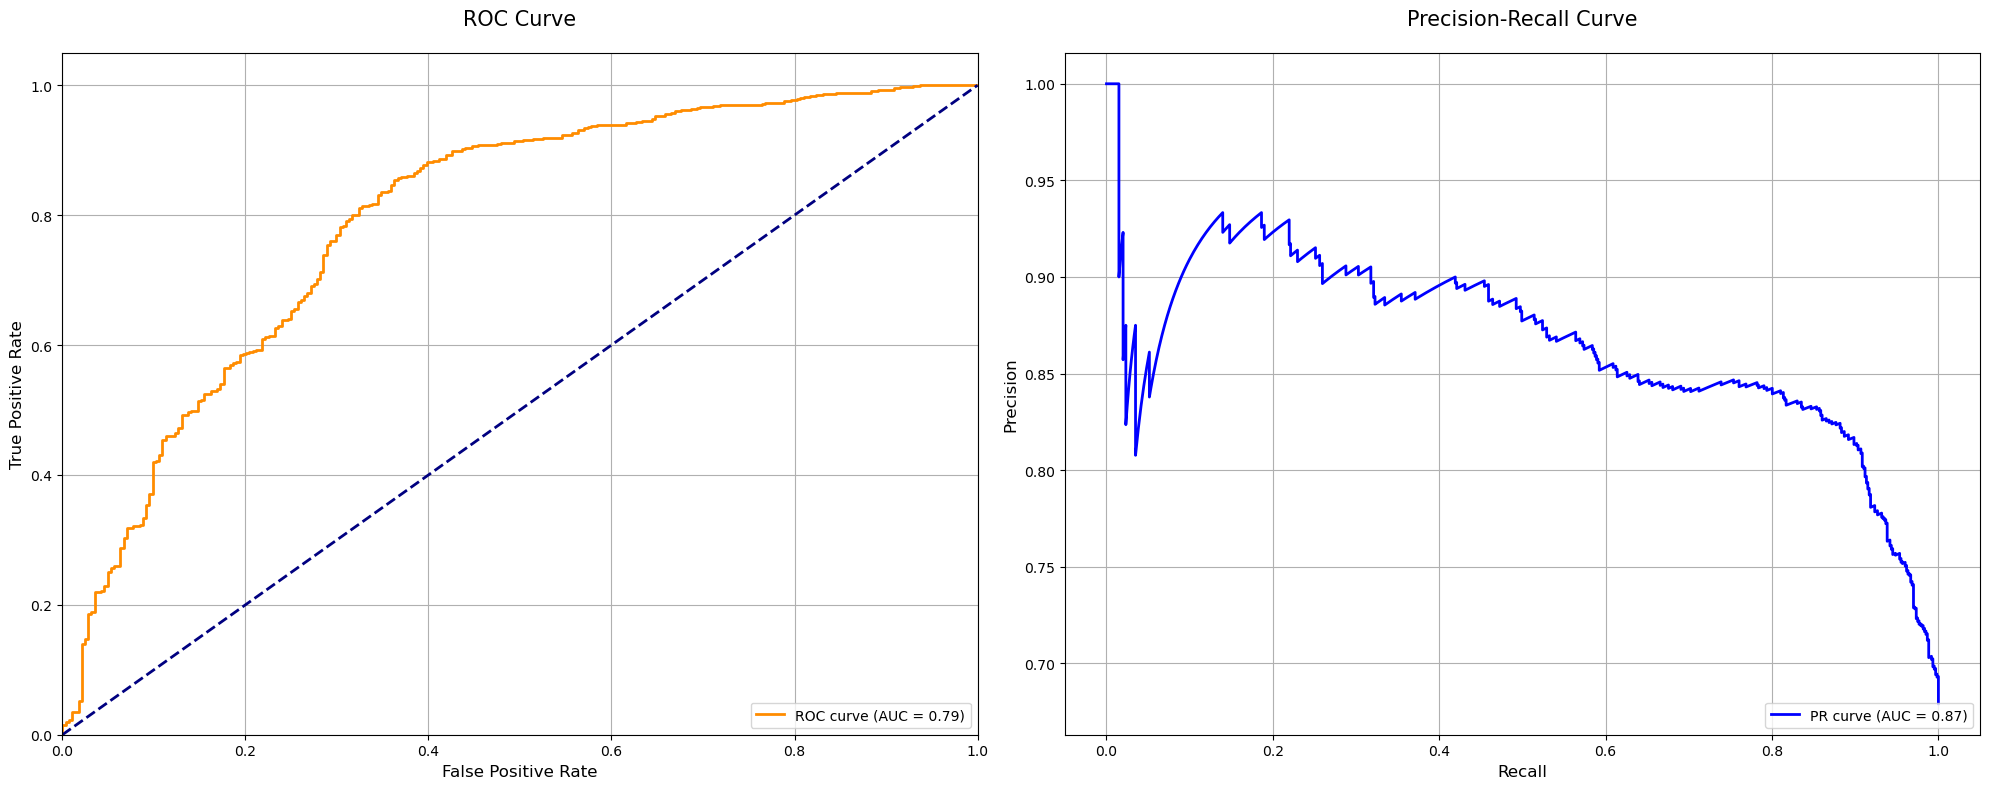

In [181]:
print('testing with preprocessed data')
fit_and_eval(best_poly_pp, polynomial_kernel, 'polynomial', pp_X_train, pp_y_train, pp_X_test, pp_y_test)

testing with preprocessed data

gaussian kernel - Test Metrics:
  Accuracy     : 0.8136
  Log-Loss     : 6.7200
  Precision    : 0.8045
  Recall       : 0.9584
  F1 Score     : 0.8747

Confusion Matrix for gaussian Kernel:


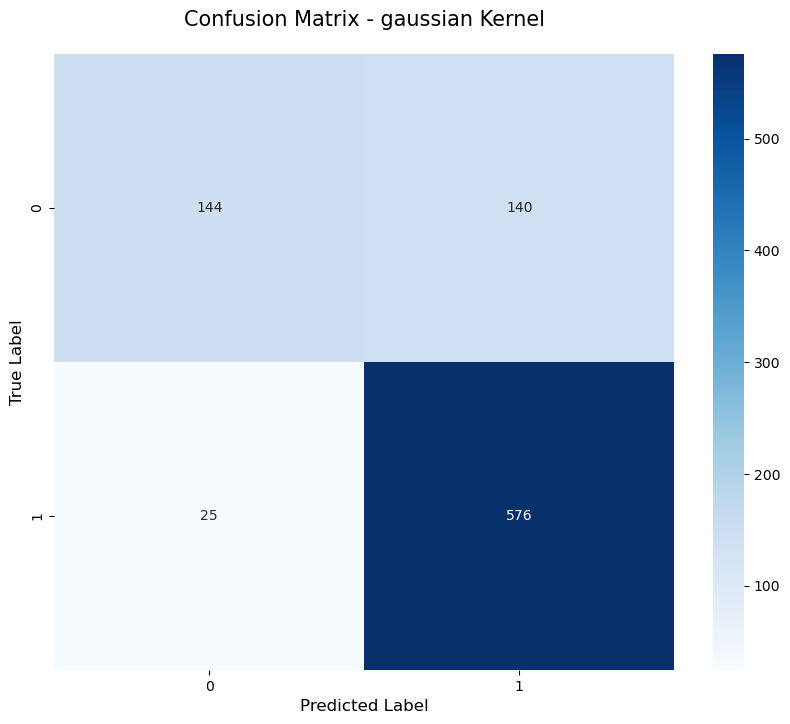


ROC and PR Curves for gaussian Kernel:


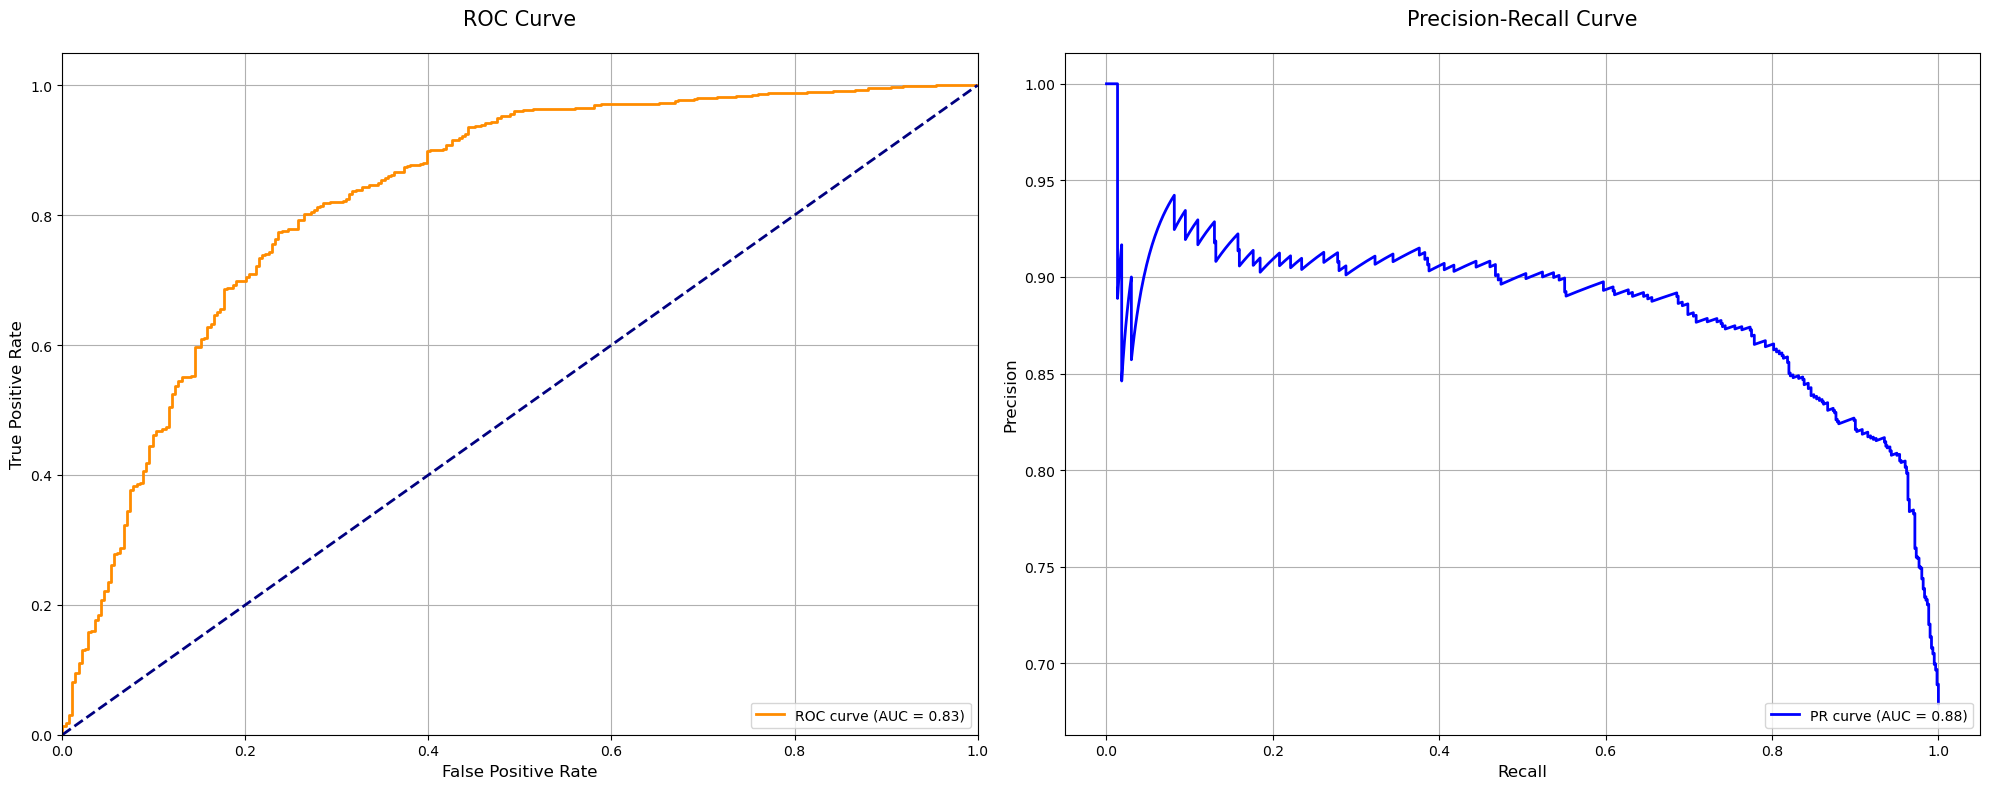

In [182]:
print('testing with preprocessed data')
fit_and_eval(best_gaussian_pp, gaussian_kernel, 'gaussian', pp_X_train, pp_y_train, pp_X_test, pp_y_test)